In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [ ]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [ ]:
#uncomment this decorator to test your code
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):

    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.111111111111111)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x,y,theta = curr_pose
    x += v*np.cos(theta)*dt 
    y += v*np.sin(theta)*dt
    theta += (v/0.9)*np.tan(delta)*dt

    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return (x, y, theta)

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.111111111111111)
ok


In [ ]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for v,delta in zip(all_v,all_delta):
   #instruction to take v, delta and compute new pose    
   straight_trajectory.append(pose)   
   new_pose = bicycle_model(pose, v, delta)
   # store new pose
   pose = new_pose
straight_trajectory = np.array(straight_trajectory)

In [ ]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps*100)
all_delta = np.ones(steps*100)
for v,delta in zip(all_v, all_delta):
    #instruction to take v, w and compute new pose 
    circle_trajectory.append(pose)      
    new_pose = bicycle_model(pose, v, delta)
    # store new pose
    pose = new_pose
circle_trajectory = np.array(circle_trajectory)

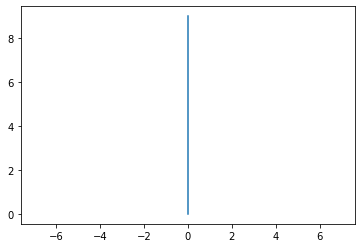

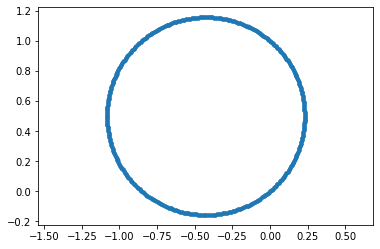

In [ ]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])

plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1],'.')

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [ ]:
v_c = 1 # m/s
delta_c = np.pi/6 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi*0.9/2*v_c*np.tan(delta_c))

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c)

all_delta = [0]*t_straight1 + [-delta_c]*t_turn + [0]*t_straight2 + [delta_c]*t_turn + [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [ ]:
def get_open_loop_commands(route, vcfast, vcslow, deltac,dt=1):
    all_delta = []
    all_v = []
    deltas = {"straight":0, "left":deltac, "right":-deltac}
    for maneuver,value in route:
        u = deltas[maneuver]
        angle_step = np.ceil(np.deg2rad(value)*0.9/(vcslow*np.tan(deltac)*dt))
        all_delta += [u]*np.ceil(value/(vcfast*dt)).astype(int) if maneuver == "straight" else [u]*angle_step.astype(int)
        all_v += [vcfast]*np.ceil(value/(vcfast*dt)).astype(int) if maneuver == "straight" else [vcslow]*angle_step.astype(int)
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [ ]:
dt = 0.2
all_v,all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],1,0.5,np.pi/12,dt)
print(len(all_v))


158


In [ ]:
robot_trajectory = []
pose = (0, 0, np.pi/2)
for v, delta in zip(all_v, all_delta):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose)      
    new_pose = bicycle_model(pose, v, delta,dt)
   # store new pose
    pose = new_pose
robot_trajectory = np.array(robot_trajectory)
   

158


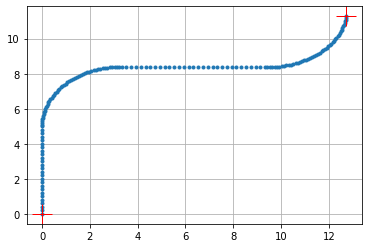

In [ ]:
# plot robot trajectory
plt.figure()
plt.grid()
print(len(robot_trajectory))
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1],'.')
#show first and last robot positions with + markers
x0,y0,_ = robot_trajectory[0,:]
xf,yf,_ = robot_trajectory[-1,:]
# example: plt.plot(0, 0, 'r+', ms=10)
plt.plot(xf,yf,'r+',ms = 20)
plt.plot(x0,y0,'r+',ms = 20)


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2x^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [2]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

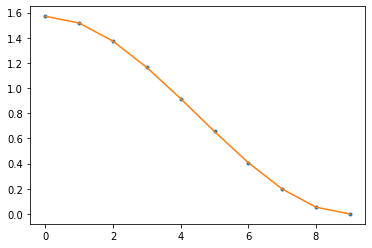

In [3]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

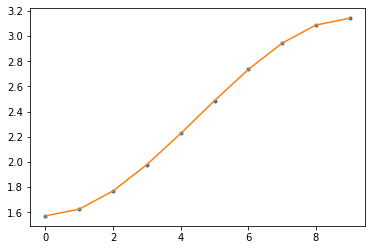

In [4]:
plt.figure()
plt.plot(poly_turn(np.pi/2,np.pi),'.')
plt.plot(poly_turn(np.pi/2,np.pi))

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


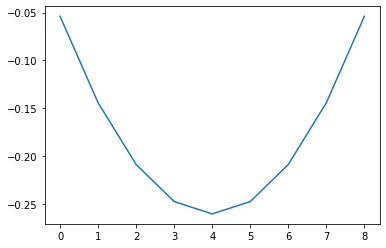

In [6]:
thetadot = np.diff(poly_turn(np.pi/2,0))
print(thetadot)
plt.plot(thetadot)

How does $\theta$ change when we had constant $\delta$? Plot it

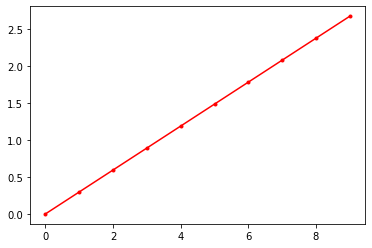

In [8]:
theta = 0
delta = np.pi/12
v = 1
L = 0.9
thetas =[]
for i in range(10):
    thetas.append(theta)
    theta+= (v/L)*np.tan(delta)
plt.plot(thetas,'r.-')


We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

[-0.04844344 -0.12920623 -0.18593495 -0.21942362 -0.23048008 -0.21942362
 -0.18593495 -0.12920623 -0.04844344]


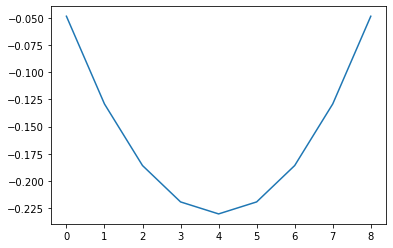

In [9]:
deltas = np.arctan(L*thetadot/v)
print(deltas)
plt.plot(deltas)